In [1]:
import string
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.model_selection import (train_test_split, learning_curve, cross_val_score, cross_val_predict, 
ShuffleSplit, KFold)
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_sm')
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "!", "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";",
                                                     "<", "=", ">", "?", "@", "[", "]", "^", "_", "`", "{", "|", "}", "~"]

dataset500 = pd.read_csv(r'SampleDataset500.csv', sep=",", engine='python')
dataset1000 = pd.read_csv(r'SampleDataset1000.csv', sep=",", engine='python')
dataset1500 = pd.read_csv(r'SampleDataset1500.csv', sep=",", engine='python')

print("Old shape:", dataset500.shape)
print("Old shape:", dataset1000.shape)
print("Old shape:", dataset1500.shape)


# Data cleaning function
def clean_data(dataset):
    # Remove punctuations
    dataset['text'] = dataset['text'].str.replace(',', " ")
    dataset['text'] = dataset['text'].str.replace('“', " ")
    dataset['text'] = dataset['text'].str.replace('’', " ")
    # Make sure any double-spaces are single
    dataset['text'] = dataset['text'].str.replace('  ', ' ')
    dataset['text'] = dataset['text'].str.replace("\n", " ").replace("\r", " ")
    dataset['text'] = dataset['text'].str.replace("  ", " ")
    # Drop duplicate rows
    dataset.drop_duplicates(subset=['text'], inplace=True)
    print("New shape:", dataset.shape)
    return dataset


data = clean_data(dataset500)
dataframe = data

data1 = clean_data(dataset1000)
dataframe1 = data1

data2 = clean_data(dataset1500)
dataframe2 = data2

rows_list = []
rows_list1 = []
rows_list2 = []


def Remove_StopWords(docs):
    lemmas = []
    for tok in docs:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
        tokens = lemmas
        tokens = [tok for tok in tokens if tok not in STOPLIST]
        tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

for output in dataframe.text:
    doc = nlp(output)
    vocabulary = Remove_StopWords(doc)
    vectorizer = CountVectorizer(tokenizer=vocabulary, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
    diction = [x.lemma_ for x in [y for y in nlp(str(vectorizer.tokenizer)) if not y.is_stop and y.pos_ != 'PUNCT']]
    rows_list.append(diction)

Old shape: (1000, 6)
Old shape: (1000, 6)
Old shape: (1000, 6)
New shape: (997, 6)
New shape: (996, 6)
New shape: (997, 6)


In [2]:
for output in dataframe1.text:
    doc = nlp(output)
    vocabulary = Remove_StopWords(doc)
    vectorizer = CountVectorizer(tokenizer=vocabulary, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
    diction = [x.lemma_ for x in [y for y in nlp(str(vectorizer.tokenizer)) if not y.is_stop and y.pos_ != 'PUNCT']]
    rows_list1.append(diction)

In [3]:
for output in dataframe2.text:
    doc = nlp(output)
    vocabulary = Remove_StopWords(doc)
    vectorizer = CountVectorizer(tokenizer=vocabulary, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
    diction = [x.lemma_ for x in [y for y in nlp(str(vectorizer.tokenizer)) if not y.is_stop and y.pos_ != 'PUNCT']]
    rows_list2.append(diction)

In [6]:
df = pd.DataFrame(rows_list)
df.append(pd.DataFrame(rows_list1))
df.append(pd.DataFrame(rows_list2))

df['News'] = df[df.columns[0:]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df["Type"] = dataframe["Type"]
dfModel = pd.DataFrame(df[{"News", "Type"}])
dfModel = dfModel.dropna()

X = dfModel.News.values
y = dfModel.Type.values

In [7]:
#CREATING_LEARNING_CURVE_FUNCTION
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Training Accuracy  1.0
Training Validated scores: Mean: 0.93 (+/- Std: 0.05)

R2 Score: 0.772572706935123

Predicted Accuracy score 94.31%
Misclassified samples: 17

execution time is 12.257962942123413


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

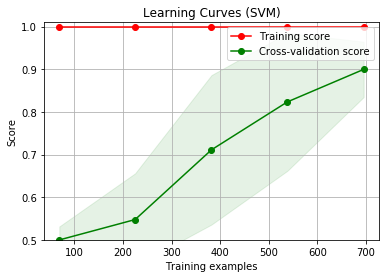

In [8]:
# SVM Classifier
from sklearn.svm import SVC
from sklearn import svm
start = time.time()

tf_idf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
X = dfModel.News.values
X_tf_idf = tf_idf.fit_transform(X)
y=dfModel.Type.values

#  Train the classifier
svm = svm.SVC(kernel='rbf', random_state=0, gamma=3, C=1.0)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.3)

# get predictions for article section
svm.fit(X_train, y_train)

scores = cross_val_score(svm, X_train, y_train, cv=10)
print("Training Accuracy ",svm.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = svm.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
# cross_val_score(svm,X_tf_idf , y, cv=cv)  
plot_learning_curve(svm, title, X_tf_idf, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

Logistic Regression
Training Accuracy  0.9971223021582734
Training Validated scores: Mean: 0.97 (+/- Std: 0.03)

R2 Score: 0.892706557818247

Predicted Accuracy score 97.32%
Misclassified samples: 8

execution time is 1.7787368297576904


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

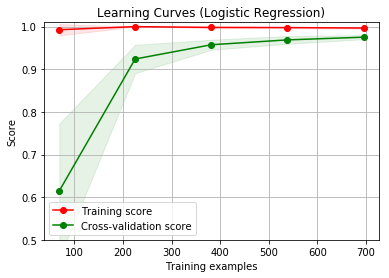

In [16]:
# Logisitic Regression
start = time.time()

X=dfModel.News.values
y = dfModel.Type.values
tf_idf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))

X_tf_idf = tf_idf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.3)

logit = LogisticRegression(solver='liblinear')

# train model
logit.fit(X_train, y_train)

print("Logistic Regression")
scores = cross_val_score(logit, X_train, y_train, cv=10)
print("Training Accuracy ",logit.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = logit.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0, train_size=0.7)
# cv=KFold(n_splits=100, random_state=None, shuffle=True)
plot_learning_curve(logit, title, X_tf_idf, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

Naive Bayes
Training Accuracy  1.0
Training Validated scores: Mean: 0.97 (+/- Std: 0.04)

R2 Score: 0.9062275985663082

Predicted Accuracy score 97.66%
Misclassified samples: 7

execution time is 1.1398603916168213


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

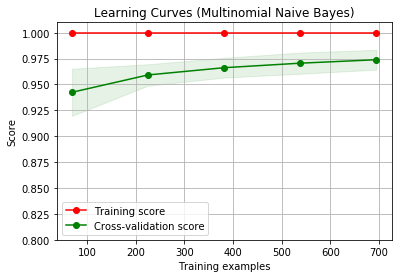

In [14]:
#Navie Bayes does the bag of words for us 
start = time.time()

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
x_vectors = bigram_vectorizer.fit_transform(dfModel.News.values)
y_vectors=dfModel.Type.values

# Build the classifier
clf = MultinomialNB(alpha=.01)
X_train, X_test, y_train, y_test = train_test_split(x_vectors, y_vectors, test_size=0.3)

#  Train the classifier
clf.fit(X_train,y_train)

print("Naive Bayes")
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Training Accuracy ",clf.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = clf.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (Multinomial Naive Bayes)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0, train_size=0.7)
plot_learning_curve(clf, title, x_vectors, y_vectors, ylim=(0.8, 1.01), cv=cv, n_jobs=4)

Random Forest Classfier
Training Accuracy  1.0
Training Validated scores: Mean: 0.96 (+/- Std: 0.06)

R2 Score: 0.9195959595959596

Predicted Accuracy score 97.99%
Misclassified samples: 4

execution time is 2.6345558166503906


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

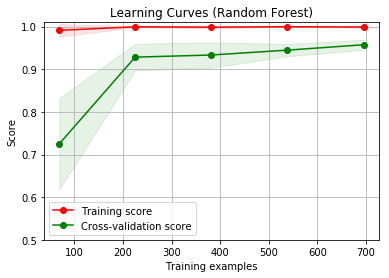

In [11]:
# Random_forest_classifier
start = time.time()

vectorizer = CountVectorizer(analyzer = 'word',stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
x_vectors = vectorizer.fit_transform(dfModel.News.values)
y = dfModel.Type.values
X_train, X_test, y_train, y_test = train_test_split(x_vectors, y, test_size=0.2, random_state=42) # Get a training and test dataset

# n_estimators is the number of random forests to use
# n_jobs says to use all processors available
rf = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
rf.fit(X_train, y_train)

print("Random Forest Classfier")
scores = cross_val_score(rf, X_train, y_train, cv=10)
print("Training Accuracy ",rf.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = rf.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0, train_size=0.7)
# cv=KFold(n_splits=100, random_state=None, shuffle=True)
plot_learning_curve(rf, title, x_vectors, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)